In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# CAVEAT

THIS NOTEBOOK IS JUST AN EXAMPLE OF CURVE FITTING ON SOME REAL WORD DATA.

PLEASE REFRAIN TO TAKE ANY DECISION OR TO EXTRAPOLATE ANY RECOMMANDATION BASED ON THIS NOTEBOOK.

**PLEASE STICK TO OFFICIAL RECOMMENDATION AND INFORMATION!**

* https://www.who.int/emergencies/diseases/novel-coronavirus-2019

# Load the data provided by JHU 

In [2]:
# Data source: https://github.com/CSSEGISandData/COVID-19
!cd DATA && git pull && cd ../

Already up to date.


In [3]:
#df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [4]:
# Drop data from 2020-03-12 because for many country data for this day was a replica from the previous day.
df_confirmed.drop(columns=['3/12/20'], inplace=True)

In [5]:
# Pivot the data: wide to long
df_confirmed_pivoted = df_confirmed.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().to_frame('Cases').reset_index()
df_confirmed_pivoted = df_confirmed_pivoted.rename(columns={'level_4' : 'Date'})
df_confirmed_pivoted['Date'] = pd.to_datetime(df_confirmed_pivoted['Date'])
df_confirmed_pivoted = df_confirmed_pivoted.groupby(['Country/Region','Date'])['Cases'].sum().to_frame('Cases').reset_index()

# Models and other amenities

In [6]:
# Exponential model
def exponential_model(x, *pars): 
    return pars[0]+np.exp(pars[1]*x+pars[2])
    
# Logistic model
def logistic_model(x, *pars): 
    return pars[0]+pars[1]/(1+np.exp(-pars[2]*(x-pars[3])))

def fit_model(xdata, ydata, model, p0=[1,1,1]):

    popt, pcov = scipy.optimize.curve_fit(model, xdata, ydata,
                                          p0=p0, 
                                          method='trf',
                                          sigma=np.sqrt(ydata),
                                          absolute_sigma=False,
                                          max_nfev=50000)

    r_square = 1 - np.square(ydata-model(xdata, *popt)).sum() / np.var(ydata)
    
    return popt, pcov, r_square

def model_error(xdata, model, pars, cov):
    
    func = lambda pars, args : model(args, *pars)

    eps = np.finfo(np.float16).eps

    err = []
    for x in xdata:
        g = scipy.optimize.approx_fprime(pars, func, eps, x)
        e = np.sqrt(np.dot(g, np.dot(cov,g.T)))
        err.append(e)
        #print(x,popt,g,e)
    
    err=np.array(err)
    return err

def print_fit_results(popt, pcov, r_square):
    
    print('Fit Parameters:')
    print(popt)
    print()
    print('Parameter errors:')
    print(np.sqrt(np.diag(pcov)))
    print()
    print('Covariance matrix:')
    print(pcov)
    print()
    print('R-square: %.3f'% r_square)

def forecast(start_date, start_day, n_days, model, popt, pcov):
    
    index = np.arange(start_day, start_day+n_days)
    
    #perr = np.sqrt(np.diag(pcov))
    
    forecast = model(index, *popt)
    error = model_error(index, model, popt, pcov)

    df = pd.DataFrame(
        index=index,
        data={
            'Date': pd.date_range(start=start_date, periods=n_days),
            'Forecast' : forecast,
            '1s_sup' : forecast+error,
            '1s_inf' : forecast-error,
            '2s_sup' : forecast+2*error,
            '2s_inf' : forecast-2*error,
            #'Forecast_sup' : model(index, *(popt+perr)),
            #'Forecast_inf' : model(index, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df
    
def predict(dates, days, model, popt, pcov):
    
    #perr = np.sqrt(np.diag(pcov))
    
    pred = model(days, *popt)
    error = model_error(days, model, popt, pcov)

    
    df = pd.DataFrame(
        data={
            'Date': dates,
            'Model' : pred,
            '1s_sup' : pred+error,
            '1s_inf' : pred-error,
            '2s_sup' : pred+2*error,
            '2s_inf' : pred-2*error,
            #'Model_sup' : model(days, *(popt+perr)),
            #'Model_inf' : model(days, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df

def plot_model(df_prediction, df_forecast, label='', ax=None, **kwargs):
    # Create axis if none is passed
    if ax == None:
        _,ax = plt.subplots(figsize=(15,15))
    # Provide a default color if none is passed
    if 'color' not in kwargs:
        kwargs['color'] = 'k'    
    # Prediciton
    df_prediction.plot('Date', 'Model', color=kwargs['color'], linestyle='-', alpha=0.5, label=label, ax=ax)
    df_prediction.plot('Date', '1s_sup', color=kwargs['color'], linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
    df_prediction.plot('Date', '1s_inf', color=kwargs['color'], linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
    # Forecast
    df_forecast.plot('Date', 'Forecast', color=kwargs['color'], linestyle='--', alpha=0.5, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '1s_sup', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '1s_inf', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '2s_sup', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '2s_inf', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    ax.fill_between(df_forecast['Date'], df_forecast['1s_inf'], df_forecast['1s_sup'], facecolor=kwargs['color'], alpha=0.1)
    ax.fill_between(df_forecast['Date'], df_forecast['2s_inf'], df_forecast['2s_sup'], facecolor=kwargs['color'], alpha=0.1)

# Fit data for Italy

In [7]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
dfit = dfit.loc[dfit['Cases'] > 100]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

# Stop the fit 3 days ago. Use the last 3 point to verify (qualitatively) the fit prediction power.
ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
ydata_exp=dfit['Cases'][-20:-3]
xdata_exp=dfit['ndays'][-20:-3]
p0=[-4.76730302e+02,1.72669390e-01,6.13355554e+00]
popt, pcov, r_square_exp = fit_model(xdata_exp, ydata_exp, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[10, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-6.35119338e+07  1.18722781e-05  1.79666094e+01]

Parameter errors:
[6.75428743e-14 1.66049198e-07 4.28922402e-06]

Covariance matrix:
[[ 4.56203986e-27 -1.10147883e-20  2.89706519e-19]
 [-1.10147883e-20  2.75723362e-14 -6.99480059e-13]
 [ 2.89706519e-19 -6.99480059e-13  1.83974427e-11]]

R-square: 0.939

-----------------
Logistic model
-----------------

Fit Parameters:
[-2.84925984e+02  2.02507676e+04  1.69783778e-01  2.37660574e+01]

Parameter errors:
[2.60548054e+01 2.96462007e+02 2.76695243e-03 1.95658831e-01]

Covariance matrix:
[[ 6.78852885e+02 -5.42703209e+03  6.34156635e-02 -3.10898674e+00]
 [-5.42703209e+03  8.78897215e+04 -7.20694130e-01  5.56930614e+01]
 [ 6.34156635e-02 -7.20694130e-01  7.65602578e-06 -4.65543116e-04]
 [-3.10898674e+00  5.56930614e+01 -4.65543116e-04  3.82823780e-02]]

R-square: 0.988


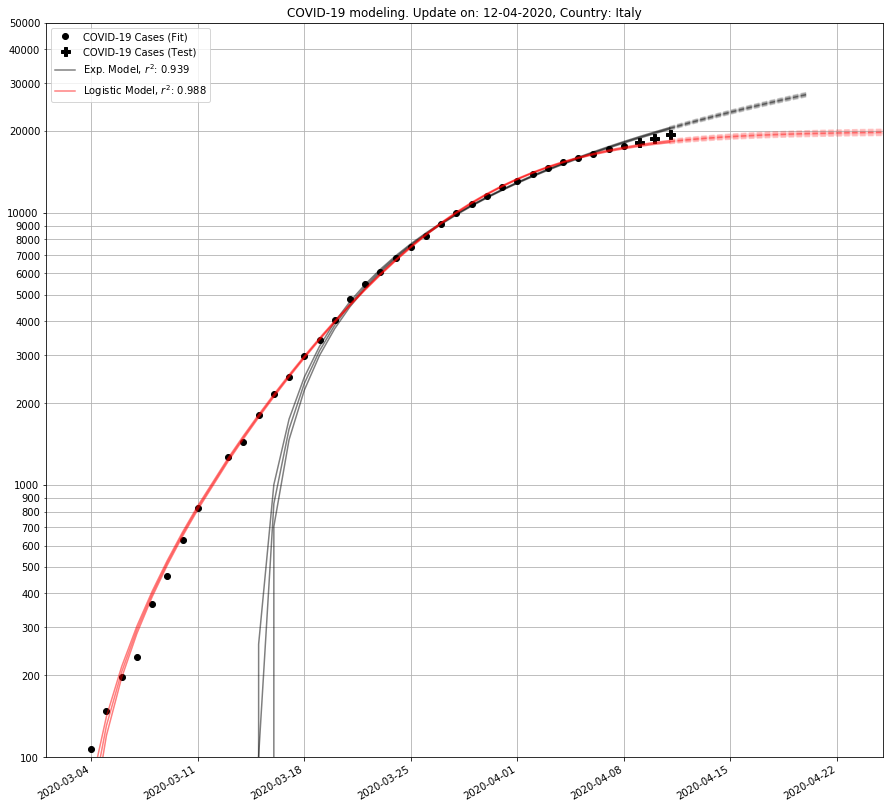

In [8]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-25'])
ax.set_ylim([100, 50000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

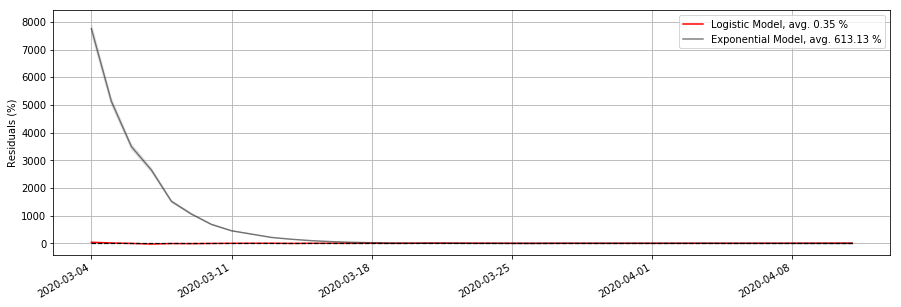

In [9]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()

## Logistic model: forecast 30 days ahead

In [10]:
display(df_forecast_logit)

,Date,Forecast,1s_sup,1s_inf,2s_sup,2s_inf,Uncertainty
38,2020-04-11,18307.128995,18466.751214,18147.506776,18626.373433,17987.884556,159.622219
39,2020-04-12,18548.007059,18720.358163,18375.655955,18892.709267,18203.304851,172.351104
40,2020-04-13,18756.180772,18940.366954,18571.994589,19124.553137,18387.808406,184.186183
41,2020-04-14,18935.461624,19130.525568,18740.397681,19325.589512,18545.333737,195.063944
42,2020-04-15,19089.394736,19294.361381,18884.428091,19499.328026,18679.461446,204.966645
43,2020-04-16,19221.222008,19435.131751,19007.312264,19649.041494,18793.402521,213.909743
44,2020-04-17,19333.867787,19555.799550,19111.936024,19777.731313,18890.004261,221.931763
45,2020-04-18,19429.940730,19659.027028,19200.854431,19888.113327,18971.768133,229.086298
46,2020-04-19,19511.746670,19747.182549,19276.310790,19982.618428,19040.874911,235.435879
47,2020-04-20,19581.308402,19822.355749,19340.261055,20063.403097,19099.213708,241.047347


## Fit stability
### Logistic model

In [11]:
#dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
#dfit = dfit.loc[dfit['Cases'] > 10]

#dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

#ydata=dfit['Cases'] 
#xdata=dfit['ndays']

#p0=popt
p0=[10, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]

fit_stab = []

for i in range(len(xdata))[::-1]:
    
    if i != 0:
        
        ipopt, ipcov, irsquare = fit_model(xdata[:i],ydata[:i],logistic_model, p0=p0)
        fit_stab.append({
            'x': xdata.iloc[i],
            'date' : dfit['Date'].iloc[i],
            'popt' : ipopt, 
            'perr' : np.sqrt(np.diag(ipcov)), 
            'r_square' : irsquare
        })

In [12]:
df=pd.DataFrame(fit_stab)

tmp_1=df.date.apply(pd.Series)
tmp_1.columns=['date']
tmp_2=df.popt.apply(pd.Series)
tmp_2.columns=['popt_0', 'popt_1', 'popt_2', 'popt_3']
tmp_3=df.perr.apply(pd.Series)
tmp_3.columns=['perr_0', 'perr_1', 'perr_2', 'perr_3']

df = pd.concat([tmp_1, tmp_2, tmp_3, df.r_square], axis=1)

df = df.sort_values(by='date').reset_index(drop=True)

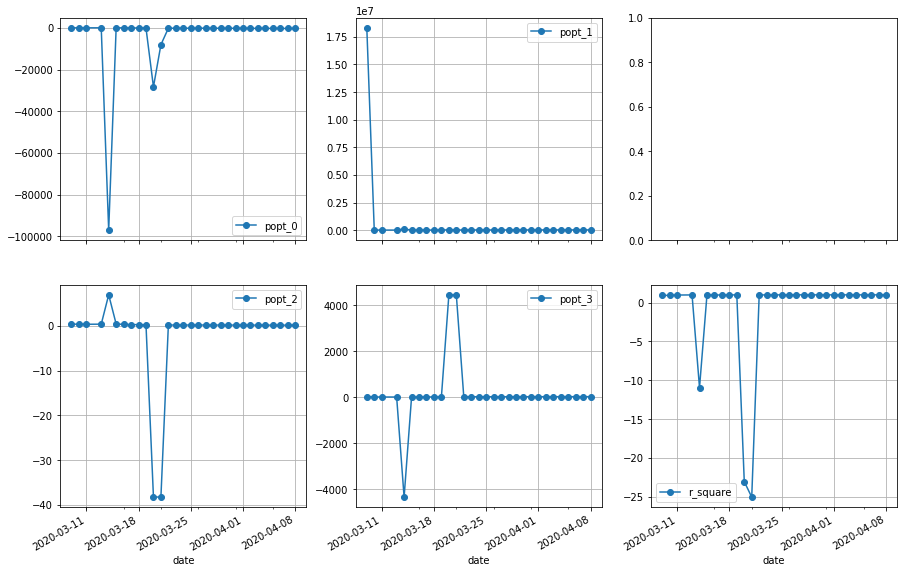

In [13]:
f, ax = plt.subplots(2, 3, sharex=True, figsize=(15,10))

#df[-10:].plot(x='date', y='popt_0', yerr='perr_0', marker='o', grid=True, ax=ax[0][0])
#df[-10:].plot(x='date', y='popt_1', yerr='perr_1', marker='o', grid=True, ax=ax[0][1])
#df[-10:].plot(x='date', y='popt_2', yerr='perr_2', marker='o', grid=True, ax=ax[1][0])
#df[-10:].plot(x='date', y='popt_3', yerr='perr_3', marker='o', grid=True, ax=ax[1][1])
#df[-10:].plot(x='date', y='r_square', marker='o', grid=True, ax=ax[1][2])

df[-30:].plot(x='date', y='popt_0', marker='o', grid=True, ax=ax[0][0])
df[-30:].plot(x='date', y='popt_1', marker='o', grid=True, ax=ax[0][1])
df[-30:].plot(x='date', y='popt_2', marker='o', grid=True, ax=ax[1][0])
df[-30:].plot(x='date', y='popt_3', marker='o', grid=True, ax=ax[1][1])
df[-30:].plot(x='date', y='r_square', marker='o', grid=True, ax=ax[1][2])


#plt.xlabel('')

plt.show()

# Fit data for France

In [14]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'France'].reset_index(drop=True)

# Drop 15/03/2020 because the data is suspicously close to the previous day
dfit=dfit.drop(52, axis=0)

dfit = dfit.loc[dfit['Cases'] > 100]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[ 0.50341354,  0.5, -0.6697555 ]
ydata_exp=dfit['Cases'][-20:-3]
xdata_exp=dfit['ndays'][-20:-3]
popt, pcov, r_square_exp = fit_model(xdata_exp, ydata_exp, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[7.27827841e+00, 9.39938381e+03, 3.32193436e-01, 3.53736033e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-1.02980416e+03  1.19964065e-01  6.68751274e+00]

Parameter errors:
[4.16332998e+02 1.07846406e-02 2.62165938e-01]

Covariance matrix:
[[ 1.73333165e+05  4.33569012e+00 -1.07193591e+02]
 [ 4.33569012e+00  1.16308474e-04 -2.81453257e-03]
 [-1.07193591e+02 -2.81453257e-03  6.87309790e-02]]

R-square: 0.812

-----------------
Logistic model
-----------------

Fit Parameters:
[-1.76636362e+02  2.31153435e+04  1.91621306e-01  2.31329539e+01]

Parameter errors:
[7.82454040e+01 4.86368473e+03 1.56339618e-02 1.92874695e+00]

Covariance matrix:
[[ 6.12234324e+03 -3.00762263e+05  1.12556690e+00 -1.21719487e+02]
 [-3.00762263e+05  2.36554292e+07 -7.13251108e+01  9.34628647e+03]
 [ 1.12556690e+00 -7.13251108e+01  2.44420760e-04 -2.88201500e-02]
 [-1.21719487e+02  9.34628647e+03 -2.88201500e-02  3.72006479e+00]]

R-square: 0.904


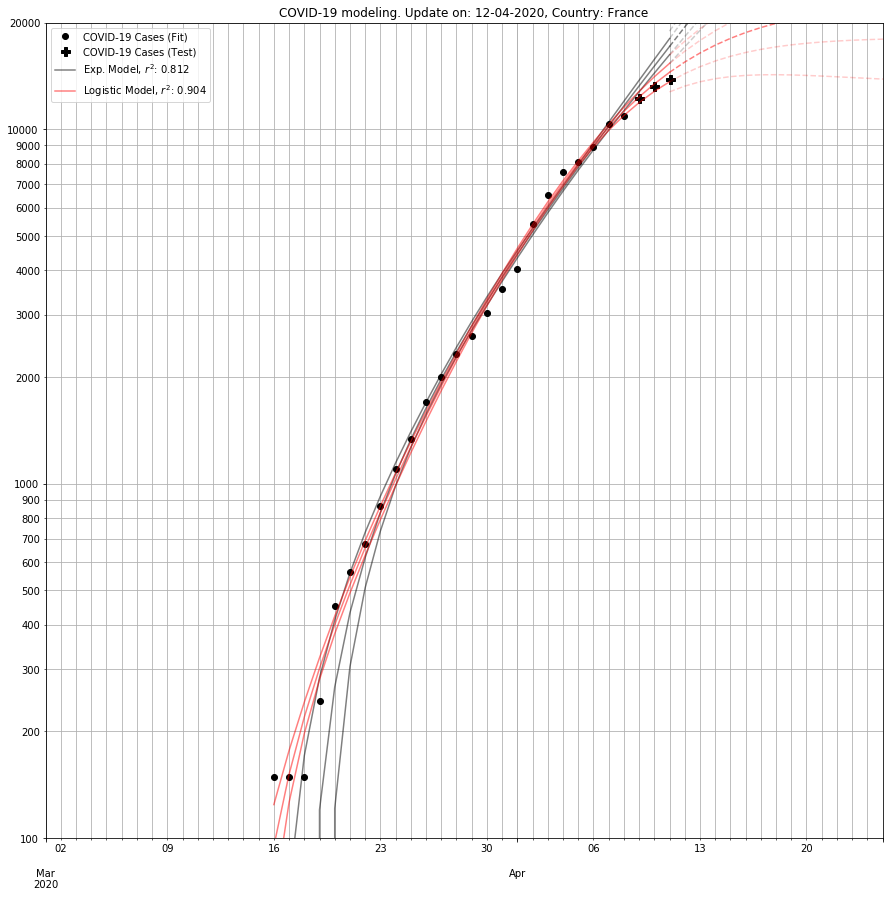

In [15]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-25'])
ax.set_ylim([100, 20000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

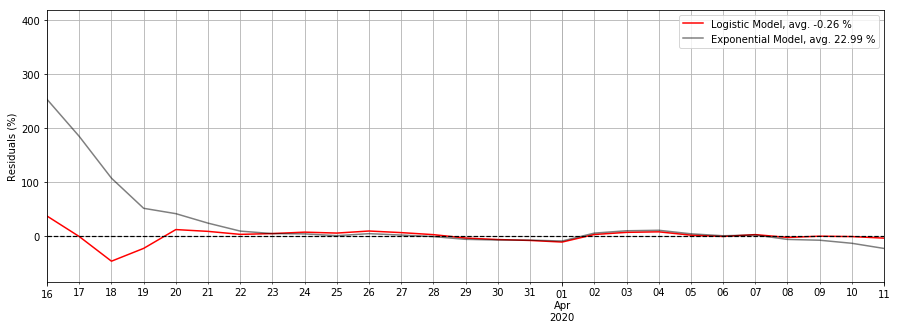

In [16]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()

# Fit data for Switzerland

In [17]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Switzerland'].reset_index(drop=True)

# Drop 16/03/2020 because the data is suspicously close to the previous day
dfit=dfit.drop(53, axis=0)

dfit = dfit.loc[dfit['Cases'] > 10]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
ydata_exp=dfit['Cases'][-20:-3]
xdata_exp=dfit['ndays'][-20:-3]
p0=[ 0.50341354,  0.5, -0.6697555 ]
popt, pcov, r_square_exp = fit_model(xdata_exp, ydata_exp, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[7.27827841e+00, 9.39938381e+03, 3.32193436e-01, 3.53736033e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-4.29654055e+02  5.87433665e-02  5.68016235e+00]

Parameter errors:
[1.20056320e+02 8.69269915e-03 3.04714232e-01]

Covariance matrix:
[[ 1.44135199e+04  1.03564742e+00 -3.65065622e+01]
 [ 1.03564742e+00  7.55630186e-05 -2.64334485e-03]
 [-3.65065622e+01 -2.64334485e-03  9.28507633e-02]]

R-square: 0.921

-----------------
Logistic model
-----------------

Fit Parameters:
[-6.40544737e+00  1.16473716e+03  2.11081258e-01  2.06075482e+01]

Parameter errors:
[2.73856581e+00 5.42271846e+01 7.63975734e-03 4.62179051e-01]

Covariance matrix:
[[ 7.49974268e+00 -1.03330521e+02  1.79920495e-02 -8.34689758e-01]
 [-1.03330521e+02  2.94058755e+03 -3.73936241e-01  2.46625711e+01]
 [ 1.79920495e-02 -3.73936241e-01  5.83658922e-05 -3.21095000e-03]
 [-8.34689758e-01  2.46625711e+01 -3.21095000e-03  2.13609476e-01]]

R-square: 0.978


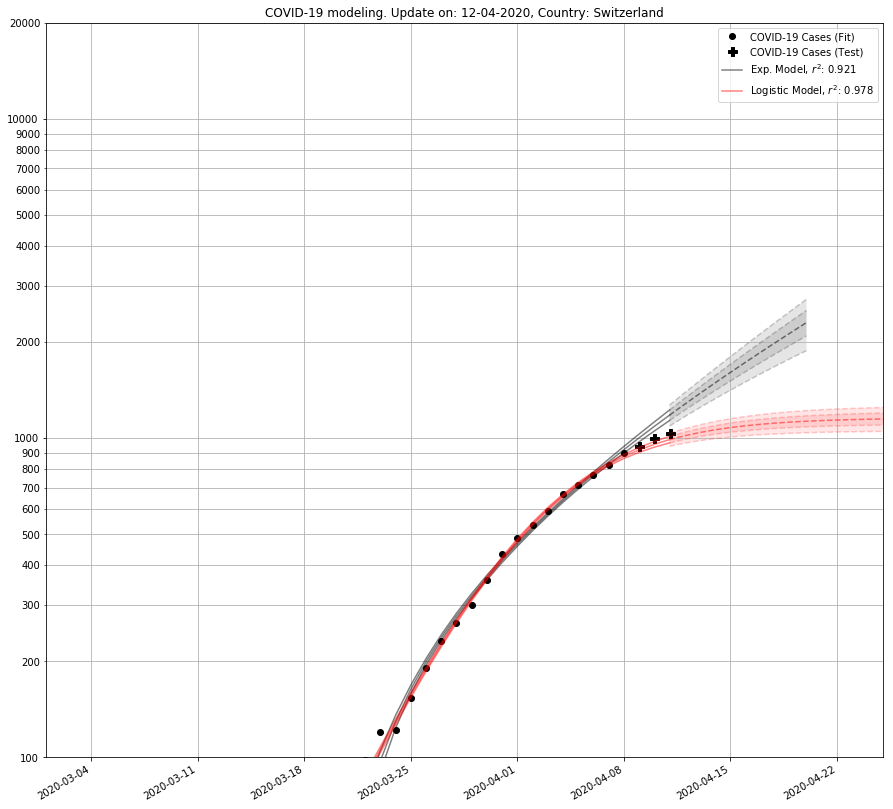

In [18]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-25'])
ax.set_ylim([100, 20000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

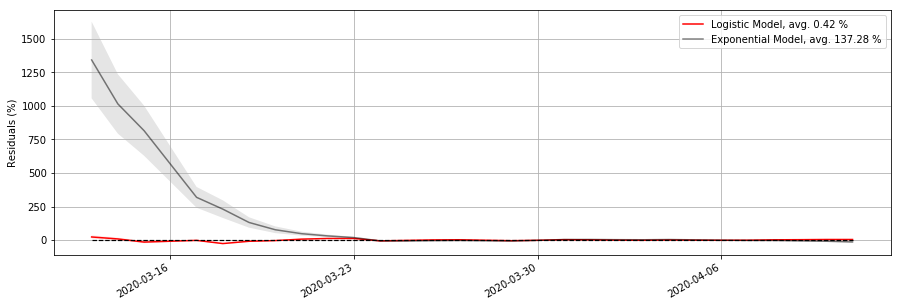

In [19]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()